# 1. 인물 모드

개념 정리할 때와 마찬가지로 인물 모드를 해 보았다. 각각 셀카 사진, 걸그룹 사진, 고양이 사진 3개를 이용해 보고자 한다. 그 전에 importlib.metadata라는 모듈은 설치가 되어 있지 않았기 때문에 이 모듈을 먼저 설치해 준 다음 이 프로젝트에서 사용하게 될 라이브러리들의 버전을 먼저 확인하는 작업을 거쳤다. 이번 프로젝트에서는 사용하게 될 모듈 및 라이브러리의 import 및 설치가 colab에서는 잘 이루어지지 않아 주피터 노트북을 활용하기로 했다.

In [2]:
! pip install importlib.metadata

In [3]:
from importlib.metadata import version
import cv2
import pixellib

print(cv2.__version__)
print(version('pixellib'))

4.5.3
0.7.1


In [4]:
# 사진 준비 전 필요한 라이브러리 미리 불러들이기
import os
import urllib
import numpy as np

# 요 pixellib.semantic이 설치가 되게 까다롭다.
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

## 1.1 셀카 사진

첫 번째 사진으로는 본인의 얼굴이 나오는 경치가 잘 나오는 사진 한 장을 가져왔다.

(1440, 1080, 3)


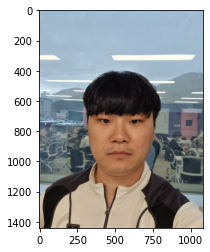

In [6]:
img_path = os.getenv('HOME') + '/aiffel/human_segmentation/images/geonhee1.jpg'
img_self = cv2.imread(img_path)
print(img_self.shape)
plt.imshow(cv2.cvtColor(img_self, cv2.COLOR_BGR2RGB))
plt.show()

세그멘테이션 문제에는 FCN, SegNet, U-Net 등 많은 모델이 사용된다. 이번 프로젝트에서는 연습 때와 마찬가지로 DeepLab이라는 세그멘테이션 모델을 이용할 것이다.

In [7]:
# 먼저, PixelLib에서 제공해 주는 모델을 다운로드해야 한다.

# 저장할 파일 이름을 결정.
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url이다.
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f8e94098ac0>)

In [8]:
# PixelLib로 우리가 사용할 세그멘테이션 모델 생성
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [9]:
# 모델에 이미지를 입력
segvalues, output = model.segmentAsPascalvoc(img_path)

In [10]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'    
]
len(LABEL_NAMES)

21

background를 제외하면 총 20개의 인덱스가 있다. 20의 의미는 tv가 될 것이다. 우리는 이 중에서 15번 인덱스에 해당하는 person 영역만을 검출해 내고 싶다.

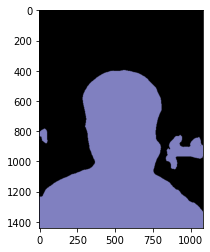

In [11]:
# 모델 출력
plt.imshow(output)
plt.show()

In [12]:
segvalues

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]])}

In [13]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


In [14]:
# 아래 코드를 이해하지 않아도 좋다.
# PixelLib에서 그대로 가져온 코드
# 주목해야 할 것은 생상 코드 결과물!
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [15]:
seg_color = (128, 128, 192)

(1440, 1080)


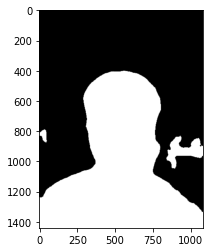

In [16]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

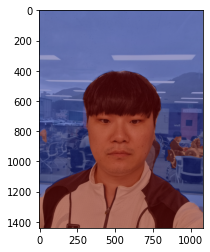

In [17]:
img_show = img_self.copy()

# True과 False인 값을 각각 255과 0으로 바꿔준다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔보기
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합치기
# 0.6과 0.4는 두 이미지를 섞는 비율을 의미한다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

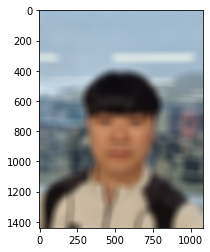

In [18]:
# 배경 흐리게 하기. blur 함수 사용
img_self_blur = cv2.blur(img_self, (60,60))  
plt.imshow(cv2.cvtColor(img_self_blur, cv2.COLOR_BGR2RGB))
plt.show()

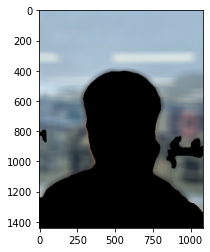

In [19]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_self_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

* bitwise_not 함수를 이용하면 이미지가 반전이 된다. 원래 마스크에서는 배경이 0, 사람이 255였으니까 이 함수를 이용한 후에는 배경이 255, 사람이 0이 되는 것이다.  


* 반전된 세그멘테이션 결과를 이용해 bitwise_and 연산을 수행하면 배경만 있는 영상을 얻을 수 있다. 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 되며, 결국 사람이 사라지게 된다.

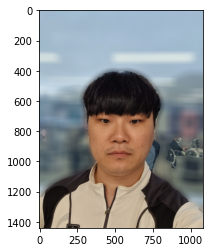

In [20]:
# 흐린 배경과 원본 영상 합성
img_concat = np.where(img_mask_color==255, img_self, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 1.2 걸그룹의 사진

이번에는 무려 걸그룹 ITZY의 단체 사진 중 잘 나온 사진 한 장을 골라 불러들였다!!! 

이미지 출처 : https://www.bandwagon.asia/articles/itzy-dedicate-release-new-song-midzy-to-their-fans-listen-jyp-entertainment-march-2021

(960, 1920, 3)


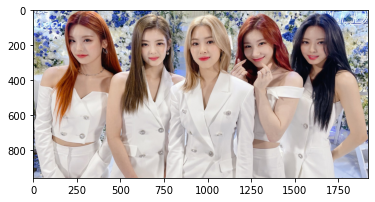

In [21]:
img_path = os.getenv('HOME') + '/aiffel/human_segmentation/images/ITZY3.jpg'
img_itzy = cv2.imread(img_path)
print(img_itzy.shape)
plt.imshow(cv2.cvtColor(img_itzy, cv2.COLOR_BGR2RGB))
plt.show()

In [22]:
# 먼저, PixelLib에서 제공해 주는 모델을 다운로드해야 한다.

# 저장할 파일 이름을 결정.
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url이다.
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f8e7010eb50>)

In [23]:
# PixelLib로 우리가 사용할 세그멘테이션 모델 생성
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [24]:
# 모델에 이미지를 입력
segvalues, output = model.segmentAsPascalvoc(img_path)

In [25]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'    
]
len(LABEL_NAMES)

21

background를 제외하면 총 20개의 인덱스가 있다. 20의 의미는 tv가 될 것이다. 우리는 이 중에서 15번 인덱스에 해당하는 person 영역만을 검출해 내고 싶다.

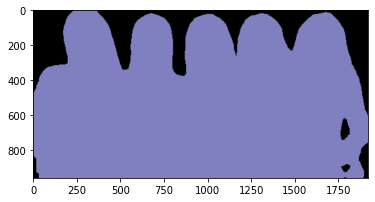

In [26]:
# 모델 출력
plt.imshow(output)
plt.show()

In [27]:
segvalues

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [28]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


In [29]:
# 아래 코드를 이해하지 않아도 좋다.
# PixelLib에서 그대로 가져온 코드
# 주목해야 할 것은 생상 코드 결과물!
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [30]:
colormap[15]

array([192, 128, 128])

output에는 세그멘테이션이 된 결과가 각각 다른 색상으로 담겨 있는 것을 알 수 있다. segvalues에는 class_ids와 masks가 있다. class_ids를 통해 어떤 물체가 담겨 있는지 알 수 있는데 여기에서는 background와 chair, person 이렇게 세 가지 물체가 담겨 있는 것을 확인한 것이다!

이제 물체마다 output에 어떤 색상으로 나타나 있는지만 알아내면 될 거 같다.

In [31]:
seg_color = (128, 128, 192)

(960, 1920)


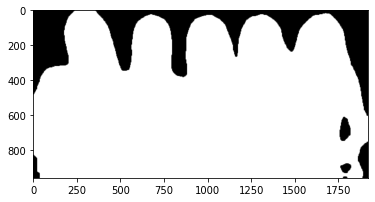

In [32]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

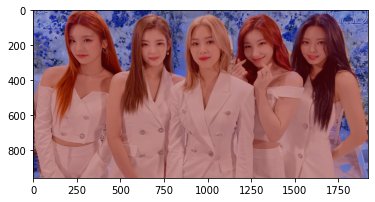

In [33]:
img_show = img_itzy.copy()

# True과 False인 값을 각각 255과 0으로 바꿔준다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔보기
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합치기
# 0.6과 0.4는 두 이미지를 섞는 비율을 의미한다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

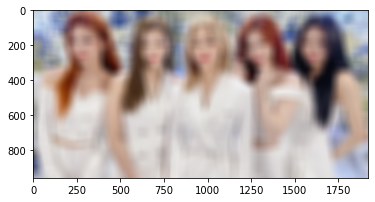

In [34]:
# 배경 흐리게 하기. blur 함수 사용
img_itzy_blur = cv2.blur(img_itzy, (60,60))  
plt.imshow(cv2.cvtColor(img_itzy_blur, cv2.COLOR_BGR2RGB))
plt.show()

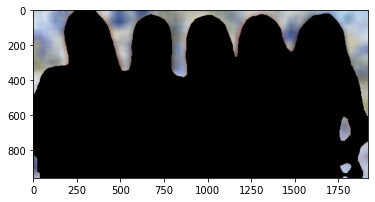

In [35]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_itzy_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))

plt.show()

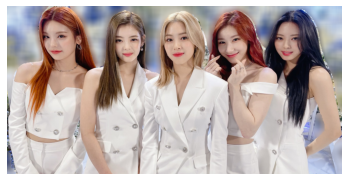

In [36]:
# 흐린 배경과 원본 영상 합성
img_concat = np.where(img_mask_color==255, img_itzy, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

## 1.3 고양이 사진

이번에는 길냥이 사진을 가져왔다.  
고양이 사진 출처 : https://www.joongang.co.kr/article/25061666

(341, 559, 3)


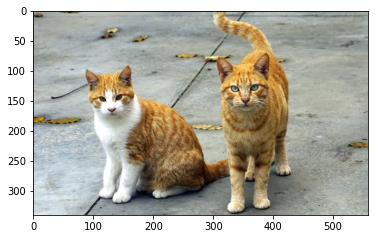

In [37]:
img_path = os.getenv('HOME') + '/aiffel/human_segmentation/images/cat.jpg'
img_cats = cv2.imread(img_path)
print(img_cats.shape)
plt.imshow(cv2.cvtColor(img_cats, cv2.COLOR_BGR2RGB))
plt.show()

In [38]:
# 먼저, PixelLib에서 제공해 주는 모델을 다운로드해야 한다.

# 저장할 파일 이름을 결정.
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url이다.
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f8e70173fa0>)

In [39]:
# PixelLib로 우리가 사용할 세그멘테이션 모델 생성
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [40]:
# 모델에 이미지를 입력
segvalues, output = model.segmentAsPascalvoc(img_path)

In [41]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'    
]
len(LABEL_NAMES)

21

background를 제외하면 총 20개의 인덱스가 있다. 20의 의미는 tv가 될 것이다. 우리는 이 중에서 8번 인덱스에 해당하는 cat 영역만을 검출해 내고 싶다.

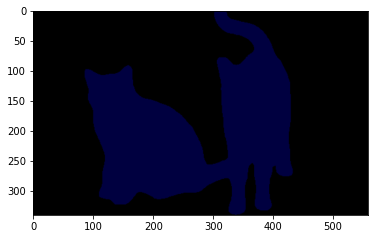

In [42]:
# 모델 출력
plt.imshow(output)
plt.show()

In [43]:
segvalues

{'class_ids': array([0, 8]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [44]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
cat


In [45]:
# 아래 코드를 이해하지 않아도 좋다.
# PixelLib에서 그대로 가져온 코드
# 주목해야 할 것은 생상 코드 결과물!
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [46]:
colormap[8]

array([64,  0,  0])

In [47]:
seg_color = (0, 0, 64)

(341, 559)


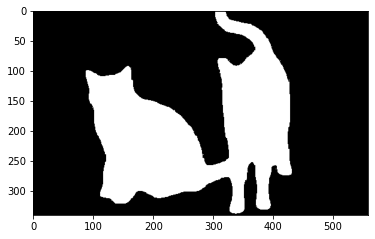

In [48]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

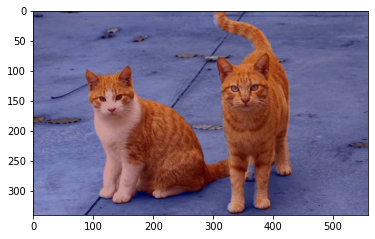

In [49]:
img_show = img_cats.copy()

# True과 False인 값을 각각 255과 0으로 바꿔준다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔보기
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합치기
# 0.6과 0.4는 두 이미지를 섞는 비율을 의미한다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

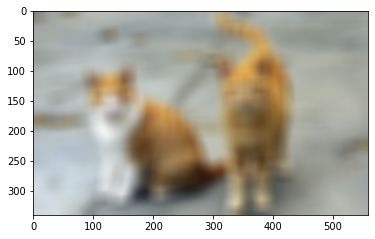

In [50]:
# 배경 흐리게 하기. blur 함수 사용
img_cats_blur = cv2.blur(img_cats, (25,25))  
plt.imshow(cv2.cvtColor(img_cats_blur, cv2.COLOR_BGR2RGB))
plt.show()

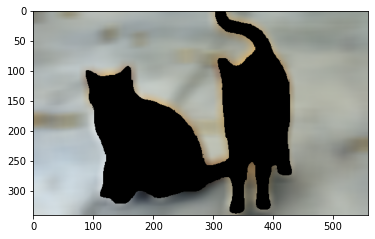

In [51]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_cats_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

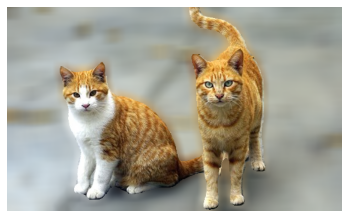

In [52]:
# 흐린 배경과 원본 영상 합성
img_concat = np.where(img_mask_color==255, img_cats, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

### 1.3.2 크로마키 배경 합성

기존 고양이 사진을 새로운 배경 사진과 교체해보는 시도를 해 보기로 했다.

(534, 950, 3)


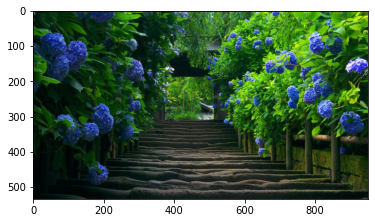

In [53]:
img_path = os.getenv('HOME') + '/aiffel/human_segmentation/images/background.jfif'
img_bg = cv2.imread(img_path)
print(img_bg.shape)
plt.imshow(cv2.cvtColor(img_bg, cv2.COLOR_BGR2RGB))
plt.show()

(341, 559, 3)


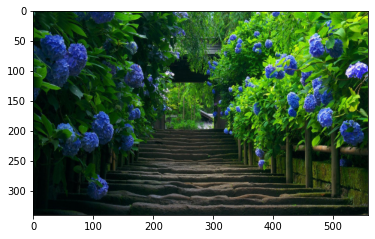

In [54]:
img_bg_res = cv2.resize(img_bg, (559, 341))
print(img_bg_res.shape)
plt.imshow(cv2.cvtColor(img_bg_res, cv2.COLOR_BGR2RGB))
plt.show()

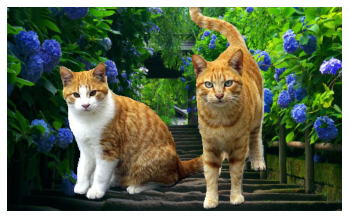

In [55]:
img_concat = np.where(img_mask_color == 255, img_cats, img_bg_res)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

처음으로 다른 배경과 고양이 사진을 합성한 나만의 사진을 완성했다. 고양이의 크기가 크게 느껴진다.

# 2. 사진 속 문제점 찾기

## 2.1 셀카 사진 속 문제점

이제까지 인물 모드 작업을 통해 배경은 흐릿하게 인물의 모습은 선명하게 나타내 주었다. 근데 개념 정리할 때 예제로 촬영했던 사진이나 제가 찍은 사진이나 어딘가 이상한 점이 보였다. 바로 본인 사진 기준으로 우측에 보이는 부분이 blur 처리가 제대로 되어 있지 않다는 것이었다. 이상한 부분을 체크한 png 형식의 이미지를 다시 불러들였다.

(214, 162, 3)


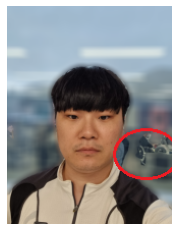

In [56]:
img_path = os.getenv('HOME') + '/aiffel/human_segmentation/images/geonhee1.png'
img_self_re = cv2.imread(img_path)
print(img_self_re.shape)
plt.imshow(cv2.cvtColor(img_self_re, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

## 2.2 걸그룹 사진 속 문제점

걸그룹 사진의 경우에는 인물과 배경 간(특히 가운데부터 우측에 있는 걸그룹 멤버들의 머리 부분)의 경계에 해당하는 부위가 깔끔하게 처리되지 못했던 문제점을 가지고 있었다. 또한 맨 우측에 있는 멤버의 팔쪽을 보면 표시된 부분 역시 blur 처리가 되지 못했다는 문제점도 있었다.

(181, 349, 3)


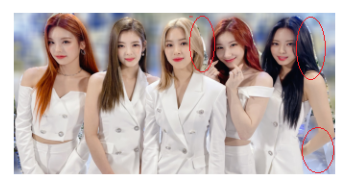

In [57]:
img_path = os.getenv('HOME') + '/aiffel/human_segmentation/images/Itzy3-1.png'
img_itzy_re = cv2.imread(img_path)
print(img_itzy_re.shape)
plt.imshow(cv2.cvtColor(img_itzy_re, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

## 2.3 고양이 사진 속 문제점

고양이 사진의 경우도 고양이 개체와 배경 화면의 경계가 되는 부분의 처리가 다소 아쉬운 부분이 있었다. 하지만 배경이 단순하고 고양이 사진 내에서는 특별히 다른 객체가 없어서 사람 모드로 촬영한 두 가지 사진에 비해서는 잘 나온 편인거 같다.

(239, 375, 3)


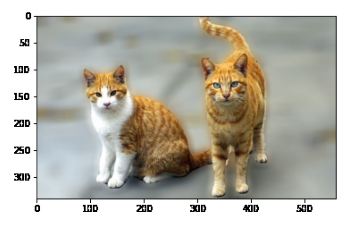

In [58]:
img_path = os.getenv('HOME') + '/aiffel/human_segmentation/images/two cats 1.png'
img_cats_re = cv2.imread(img_path)
print(img_cats_re.shape)
plt.imshow(cv2.cvtColor(img_cats_re, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# 3. 해결책 제시

Segmantic segmentation의 부정확성이 여러 가지 문제를 발생시키는 주된 원인이긴 하다. 피사계심도를 이용한 보케(아웃포커싱) 효과는 말 그대로 심도를 표현하기 때문에 초점이 잡힌 거리를 광학적으로 아주 섬세하게 구별하지만 이를 한 semantic segmentation 모듈은 정확도가 1.00이 되지 않는 한 완벽히 구현하기는 힘들다.

1) 피사계 심도 이해하기
2) 3D 카메라 활용하기
3) 소프트웨어 기술 활용하기
4) 다른 기술과 융합해 보기

노드에 나와 있는 4가지의 방법 중에 저는 피사계 심도를 이해하고 아웃 포커싱 기술을 활용하는 방안을 생각해 봤다. 아웃포커싱은 초점이 맞은 피사체 외의 배경을 흐릿하게 보이도록 하는 기술을 뜻한다. 근데 위의 사진으로 촬영한 부분이나 아이폰에서 찍은 사진이나 아웃포커싱은 기계적인 조작으로 만들어진 것이 아니라 소프트웨어를 통해 유사한 느낌을 준 것에 더 가깝다. 실제 카메라를 수동 조작했을 때 아웃포커싱이 어떻게 만들어지는지를 알면 더 다양한 사진을 찍을 수 있다.

심도는 보통 깊다(Large Depth of Field) 혹은 얕다(Narrow Depth of Field)로 표현하는데, 흔히 말하는 아웃포커싱이 된 사진은 심도가 얕다고 한다. 아웃 포커싱을 하는 방법으로는 이미지 센서의 크기, 렌즈의 초점 거리, 렌즈의 F값(초점이 맞는 거리로, Focus Distance), 사진기와 피사체와의 거리, 피사체와 배경과의 거리까지를 고려해야 한다.
카메라의 이미지 센서가 클수록, 망원 렌즈를 쓰거나 zoom을 했을 때, 조리개가 많이 개방될수록(F 값이 작을수록), 카메라와 피사체 간의 거리가 가까울 때, 피사체와 배경과의 거리가 멀수록 심도가 더 얕아져서 아웃포커싱이 잘 되게끔 하는 방법이다. 휴대폰으로 촬영하는 것보다는 아무래도 전문 카메라를 활용하여 좀 더 아웃포커싱이 잘 되게끔 사진을 촬영하는 것이 좋다고 생각한다.


아웃포커싱 기법에 관련한 블로그 : https://m.blog.naver.com/typs6301/222172333739

# 4. 회고

1) 사람 혹은 고양이나 다른 물체 등등 찍힌 대상을 포커싱하는 방법에 대해 연구해 볼 수 있는 소중한 Exploration Node였다고 생각된다.

2) 실제로 셀카, 걸그룹 사진, 사람이 아닌 고양이가 나오는 사진을 가져오고 배경까지 바꿔 보며 나만의 사진을 만들어 볼 수 있어서 여러 차례 오류가 나긴 했지만 상당히 즐거운 노드였다고 생각된다.

3) 문제점을 발견했을 때 셀카의 경우 유리창 너머에 비치는 모습도 사람 객체로 인지하고 blur 처리가 되지 않은 상태로 나온 부분이 다소 아쉬웠다. 내 모습에만 포커싱을 해 주는 아웃 포커싱을 해 보는 게 좋지 않았을까라고 생각이 들었다.(아이폰으로 바꿀까? ㅎㅎ)

4) 아직 다른 기술과 융합해 보는 방법이나 새로운 방법을 시도할 수 있을 정도로 이미지 처리에 대한 공부가 많이 부족하지만, 그래도 배우는 중이기 때문에 잘 모르더라도 하나씩 아이디어를 툭 던져 봄으로써 스스로 생각할 수 있는 힘을 키울 수 있었다.